In [1]:
# Cell 1: Import libraries and setup visualization
# Imports
import sys
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Add project src to path for imports
sys.path.insert(0, str(Path.cwd().parent / 'src'))
from synthrad.generator import (
    generate_case, 
    generate_report, 
    generate_patient_timeline,
    case_to_recist_jsonl
)
from synthrad.schema import Case

print('✅ SynthRad and visualization libraries imported!')
print()

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 100)

# Initialize random seed for reproducibility
np.random.seed(42)
random_seed_offset = 0

print(f"Setup complete. Ready to create synthetic cohorts.")
print()
print("Available functions for cohort generation:")
print("• generate_case() - Generate single patient case")
print("• generate_patient_timeline() - Generate full patient journey")
print("• case_to_recist_jsonl() - Convert to JSONL for analysis")
print("• generate_report() - Generate natural language report")


/Users/eri/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ SynthRad and visualization libraries imported!

Setup complete. Ready to create synthetic cohorts.

Available functions for cohort generation:
• generate_case() - Generate single patient case
• generate_patient_timeline() - Generate full patient journey
• case_to_recist_jsonl() - Convert to JSONL for analysis
• generate_report() - Generate natural language report


In [10]:
# Cell 2: Generate a diverse cohort with varying trajectories

import numpy as np
import pandas as pd
from synthrad.generator import generate_patient_timeline, case_to_recist_jsonl
from synthrad.schema import Case

# Configuration for diverse cohort generation
num_patients = 100  # Generate 100 patients for demo
stage_distributions = [
    {"I": 0.4, "II": 0.3, "III": 0.2, "IV": 0.1},   # Early-stage cohort
    {"I": 0.1, "II": 0.3, "III": 0.4, "IV": 0.2},   # Advanced-stage cohort  
    {"I": 0.2, "II": 0.2, "III": 0.3, "IV": 0.3},   # Late-stage cohort
]
response_distributions = [
    {"CR": 0.15, "PR": 0.25, "SD": 0.45, "PD": 0.15},  # Good responders
    {"CR": 0.05, "PR": 0.20, "SD": 0.45, "PD": 0.30},  # Mixed responders
    {"CR": 0.02, "PR": 0.10, "SD": 0.30, "PD": 0.58},  # Poor responders
]

lobes_of_interest = ["RUL", "LUL", "RLL", "LLL"]  # Skip RML for this demo

# Storage for generated data  # These variables need to carry forward
all_cases = []
all_studies = []
cohort_metadata = []

# Cohort labels for tracking
cohorts = ["Early Stage", "Advanced Care", "Late Stage"]

print(f"Generating {num_patients} patients across {len(cohorts)} different pathway cohorts...")
print(f"   ({num_patients // len(cohorts)} patients per cohort)")
print()

# Generate cohorts with different characteristics
for cohort_idx, (stage_dist, response_dist) in enumerate(zip(stage_distributions, response_distributions)):
    cohort_name = cohorts[cohort_idx]
    print(f"🎯 Generating {cohort_name} cohort...")
    
    # Generate patients for this cohort
    cohort_cases = []
    cohort_dates = []
    
    patients_per_cohort = num_patients // len(cohorts)
    for i in range(patients_per_cohort):
        patient_id = f"P{cohort_idx * patients_per_cohort + i + 1:03d}"
        
        # Vary lobes across patients in each cohort
        lobe = lobes_of_interest[i % len(lobes_of_interest)]
        
        # Generate full patient timeline (2-5 studies per patient)
        max_studies = np.random.randint(2, 6)
        rng_seed = np.random.randint(0, 1000000)
        
        cases, study_dates = generate_patient_timeline(
            patient_id=patient_id,
            seed=rng_seed,
            stage_dist=stage_dist,
            lobe=lobe,
            max_studies=max_studies,
            response_dist=response_dist
        )
        
        cohort_cases.extend(cases)
        cohort_dates.extend(study_dates)
        
        # Store metadata for tracking
        cohort_metadata.append({
            'patient_id': patient_id,
            'cohort': cohort_name,
            'baseline_stage': cases[0].tnm.stage_group if cases else 'Unknown',
            'final_stage': cases[-1].tnm.stage_group if len(cases) > 1 else cases[0].tnm.stage_group,
            'num_visits': len(cases),
            'lobe': lobe,
            'response_trajectory': [case.response_status or 'SD' for case in cases[1:]],
            'baseline_size_mm': cases[0].primary.size_mm if cases and cases[0].primary else 0
        })
        
        # Create trajectory string showing stage (response) format
        trajectory_parts = [cases[0].tnm.stage_group]  # Start with baseline stage
        for case in cases[1:]:
            response = case.response_status or 'SD'
            stage = case.tnm.stage_group
            trajectory_parts.append(f"{stage}({response})")
        
        trajectory_str = ' → '.join(trajectory_parts)
        print(f"   📄 Patient {patient_id}: {len(cases)} studies, Trajectory: {trajectory_str}")
    
    all_cases.extend(cohort_cases)
    all_studies.extend(cohort_dates)

# Convert to JSONL format for analysis
jsonl_data = case_to_recist_jsonl(all_cases, all_studies)

print()
print(f"✅ Generated {len(all_cases)} total clinical studies across {len(set([p['patient_id'] for p in cohort_metadata]))} patients")
print(f"📄 JSONL data structure: {len(jsonl_data)} study entries")
print()

# Display cohort summary
df_metadata = pd.DataFrame(cohort_metadata)
print(f"📊 Cohort Distribution:")
cohort_summary = df_metadata.groupby('cohort').agg({
    'patient_id': 'count',
    'num_visits': 'sum',
    'baseline_stage': lambda x: x.mode()[0] if not x.empty else 'N/A'
}).rename(columns={'patient_id': 'Num_Patients', 'num_visits': 'Total_Studies', 'baseline_stage': 'Most_Common_Stage'})

print(cohort_summary)
print()

# Quick preview of anatomic data we can extract
print("📊 Example of extractable anatomical data from JSON:")
if all_cases:
    sample_case = all_cases[0]
    print(f"   Patient: {sample_case.meta.patient_id}")
    print(f"   Stage: {sample_case.tnm.stage_group}")
    if sample_case.primary:
        print(f"   Primary: {sample_case.primary.lobe} lobe, {sample_case.primary.size_mm}mm")
        print(f"   Features: {', '.join(sample_case.primary.features) if sample_case.primary.features else 'None'}")
    print(f"   Nodes: {len(sample_case.nodes)} lymph nodes")
    print(f"   Mets: {len(sample_case.mets)} metastases")
    print(f"   Response: {sample_case.response_status or 'SD'}")
    
print(f"\n✅ Cohort generation complete! Ready for visualization and analysis.")


Generating 100 patients across 3 different pathway cohorts...
   (33 patients per cohort)

🎯 Generating Early Stage cohort...
   📄 Patient P001: 2 studies, Trajectory: III → III(SD)
   📄 Patient P002: 2 studies, Trajectory: III → I(SD)
   📄 Patient P003: 4 studies, Trajectory: II → I(PR) → I(PR) → I(SD)
   📄 Patient P004: 4 studies, Trajectory: II → II(PR) → II(SD) → I(SD)
   📄 Patient P005: 3 studies, Trajectory: III → III(SD) → III(SD)
   📄 Patient P006: 2 studies, Trajectory: II → II(PD)
   📄 Patient P007: 3 studies, Trajectory: IV → I(SD) → I(SD)
   📄 Patient P008: 4 studies, Trajectory: I → I(SD) → I(SD) → II(PD)
   📄 Patient P009: 2 studies, Trajectory: II → II(SD)
   📄 Patient P010: 2 studies, Trajectory: II → I(PR)
   📄 Patient P011: 2 studies, Trajectory: III → III(PR)
   📄 Patient P012: 3 studies, Trajectory: I → IV(PD) → I(SD)
   📄 Patient P013: 3 studies, Trajectory: II → II(SD) → I(PR)
   📄 Patient P014: 2 studies, Trajectory: II → I(SD)
   📄 Patient P015: 2 studies, Traje

In [14]:
# Cell 3: Extract and explore anatomical data 

print("🥼 ANALYZING ANATOMICAL DATA FROM SYNTHETIC COHORT")
print("="*60)

# Extract comprehensive anatomic data for each patient
anatomical_analysis = []

for patient_group in df_metadata.groupby('patient_id'):
    patient_id, patient_df = patient_group
    cases_for_patient = [c for c in all_cases if c.meta.patient_id == patient_id]
    cases_for_patient.sort(key=lambda x: x.meta.visit_number)
    
    patient_anatomical_data = {
        'patient_id': patient_id,
        'cohort': patient_df.iloc[0]['cohort'],
        'num_visits': len(cases_for_patient),
        'tumor_evolution': [],
        'node_evolution': [],
        'met_evolution': [],
        'staging_evolution': [],
        'response_timeline': []
    }
    
    for i, case in enumerate(cases_for_patient):
        study_data = {
            'visit_number': case.meta.visit_number,
            'stage': case.tnm.stage_group,
            'response': case.response_status or 'SD',
            'has_primary': case.primary is not None
        }
        
        # Primary tumor data
        if case.primary:
            study_data.update({
                'tumor_lobe': case.primary.lobe,
                'tumor_size_mm': case.primary.size_mm,
                'tumor_features': case.primary.features,
                't_cat': case.tnm.T
            })
            patient_anatomical_data['tumor_evolution'].append(study_data)
        
        # Lymph node data  
        node_data = []
        for node in case.nodes:
            node_info = {
                'station': node.station,
                'size_mm': node.short_axis_mm,
                'classified': node.short_axis_mm >= 10
            }
            node_data.append(node_info)
        study_data['nodes'] = node_data
        patient_anatomical_data['node_evolution'].append(study_data)
        
        # Metastases data
        met_data = []
        for met in case.mets:
            met_info = {
                'site': met.site,
                'size_mm': met.size_mm,
                'classified': met.size_mm >= 10
            }
            met_data.append(met_info)
        study_data['mets'] = met_data
        patient_anatomical_data['met_evolution'].append(study_data)
        
        patient_anatomical_data['staging_evolution'].append({
            'visit': i+1,
            'stage': case.tnm.stage_group,
            'tnm': f"{case.tnm.T}{case.tnm.N}{case.tnm.M}"
        })
        
        patient_anatomical_data['response_timeline'].append({
            'visit': i+1,
            'response': case.response_status or 'SD'
        })
    
    anatomical_analysis.append(patient_anatomical_data)

print(f"📊 Extracted anatomical data for {len(anatomical_analysis)} patients")
print()

# Summary statistics
print("🔍 COHORT ANATOMICAL SUMMARY:")
print("-" * 40)

all_tumors = []
all_nodes = []
all_mets = []
stages_over_time = []
response_distributions = []

for analysis in anatomical_analysis:
    patient_tumors = [visit for visit in analysis['tumor_evolution']]
    patient_nodes = []
    patient_mets = []
    
    for visit in analysis['tumor_evolution']:
        if visit['has_primary']:
            all_tumors.append({
                'patient_id': analysis['patient_id'],
                'lobe': visit['tumor_lobe'],
                'size_mm': visit['tumor_size_mm'],
                'stage': visit['stage']
            })
    
    for visit_data in analysis['node_evolution']:
        for node in visit_data.get('nodes', []):
            patient_nodes.append(node)
            all_nodes.append(node)
        for met in visit_data.get('mets', []):
            patient_mets.append(met)
            all_mets.append(met)
        
        stages_over_time.append(visit_data['stage'])
        response_distributions.append(visit_data.get('response', 'SD'))

print(f"▪️ Tumor Analysis: {len(all_tumors)} measurements across cohort")
if all_tumors:
    tumor_sizes = [t['size_mm'] for t in all_tumors]
    print(f"   Size range: {min(tumor_sizes)} - {max(tumor_sizes)}mm")
    print(f"   Average size: {np.mean(tumor_sizes):.1f}mm")
    
print(f"▪️ Node Analysis: {len(all_nodes)} node observations")
if all_nodes:
    node_sizes = [n['size_mm'] for n in all_nodes]
    print(f"   Node size range: {min(node_sizes)} - {max(node_sizes)}mm")
    print(f"   Nodes ≥10mm (RECIST target): {sum(n['classified'] for n in all_nodes)}")
    
print(f"▪️ Metastases Analysis: {len(all_mets)} metastasis observations")
if all_mets:
    met_sizes = [m['size_mm'] for m in all_mets]
    print(f"   Metastasis size range: {min(met_sizes)} - {max(met_sizes)}mm")
    print(f"   Met ≥10mm (RECIST target): {sum(m['classified'] for m in all_mets)}")

print(f"▪️ Staging Distribution: {Counter(stages_over_time)}")
print(f"▪️ Response Distribution: {Counter(response_distributions)}")
print()

# Anatomical diversity by cohort
cohort_anatomical_summary = defaultdict(list)
for analysis in anatomical_analysis:
    cohort = analysis['cohort']
    for visit in analysis['tumor_evolution']:
        if visit['has_primary']:
            cohort_anatomical_summary[cohort].append({
                'size_mm': visit['tumor_size_mm'],
                'lobe': visit['tumor_lobe'],
                'stage': visit['stage']
            })

print("🏥 COHORT-SPECIFIC ANATOMICAL CHARACTERISTICS:")
print("-" * 50)
for cohort, data in cohort_anatomical_summary.items():
    if data:
        sizes = [d['size_mm'] for d in data]
        lobes = [d['lobe'] for d in data]
        print(f"{cohort}:")
        print(f"   Avg tumor size: {np.mean(sizes):.1f}mm")
        print(f"   Overview: {Counter(lobes)}")
        print()

print("✅ Anatomical data extraction complete!")
print("📋 Ready for visualization and analysis of extracted features")


🥼 ANALYZING ANATOMICAL DATA FROM SYNTHETIC COHORT
📊 Extracted anatomical data for 99 patients

🔍 COHORT ANATOMICAL SUMMARY:
----------------------------------------
▪️ Tumor Analysis: 280 measurements across cohort
   Size range: 5 - 133mm
   Average size: 40.0mm
▪️ Node Analysis: 429 node observations
   Node size range: 8 - 18mm
   Nodes ≥10mm (RECIST target): 373
▪️ Metastases Analysis: 174 metastasis observations
   Metastasis size range: 6 - 28mm
   Met ≥10mm (RECIST target): 136
▪️ Staging Distribution: Counter({'IV': 108, 'I': 77, 'III': 74, 'II': 46})
▪️ Response Distribution: Counter({'SD': 209, 'PD': 62, 'PR': 34})

🏥 COHORT-SPECIFIC ANATOMICAL CHARACTERISTICS:
--------------------------------------------------
Early Stage:
   Avg tumor size: 32.0mm
   Overview: Counter({'LLL': 23, 'RUL': 20, 'RLL': 19, 'LUL': 18})

Advanced Care:
   Avg tumor size: 37.6mm
   Overview: Counter({'RUL': 31, 'RLL': 27, 'LLL': 22, 'LUL': 21})

Late Stage:
   Avg tumor size: 49.1mm
   Overview: Co

📊 COHORT VISUALIZATION DASHBOARD
📈 Plot 1: Patient stage evolution over time
📏 Plot 2: Primary tumor size distributions
🏥 Plot 3: Anatomical lobe distribution
🔗 Plot 4: Lymph node surveillance
📉 Plot 5: Response distribution across cohorts
🚀 Plot 6: Metastasis burden


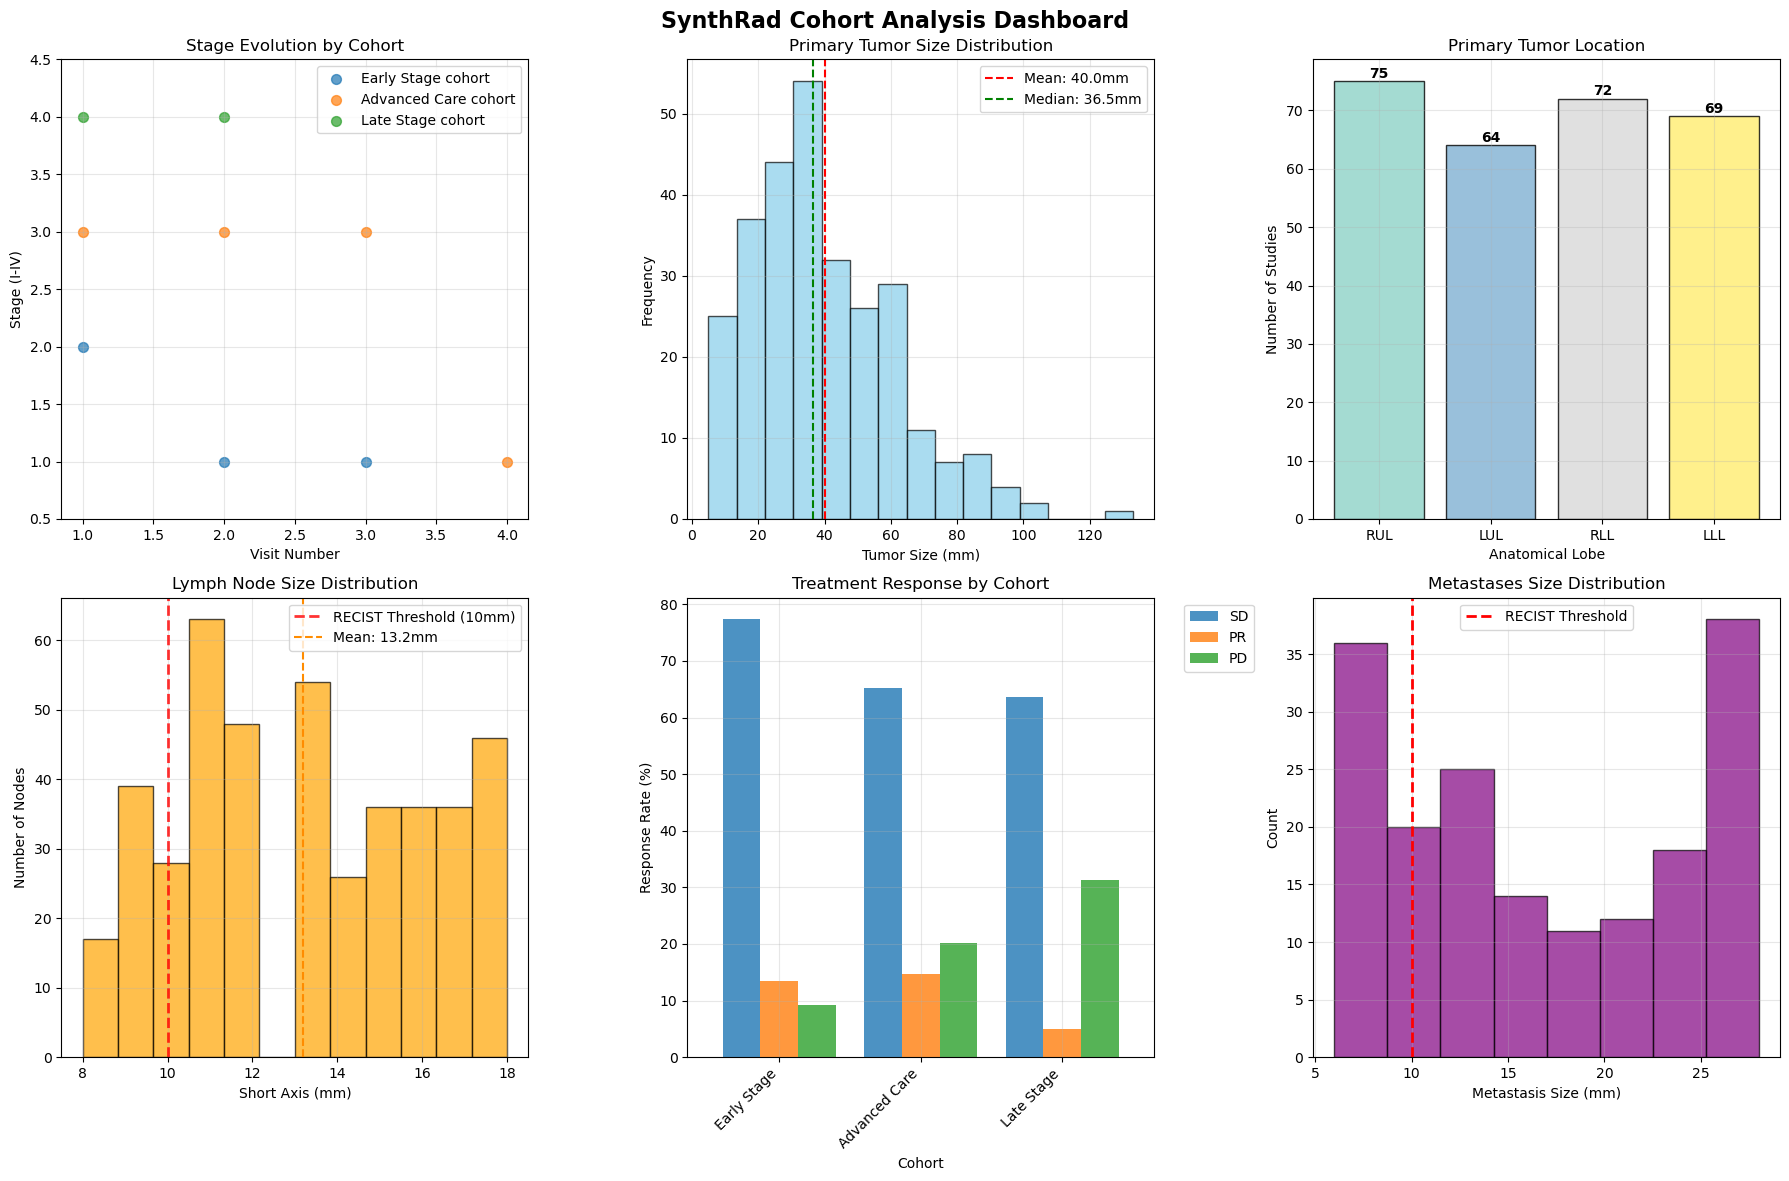


📋 Visualizations Summary:
▪️ Analyzed 99 patients across 3 cohorts
▪️ Tumor measurements: 280
▪️ Node observations: 429
▪️ Metastases: 174
✅ Cohort visualization complete!


In [15]:
# Cell 4: Visualize cohort progressions and anatomical data

print("📊 COHORT VISUALIZATION DASHBOARD")
print("="*50)

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('SynthRad Cohort Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Patient Trajectories by Cohort (Stage Evolution)
print("📈 Plot 1: Patient stage evolution over time")
ax1 = axes[0, 0]

cohort_trajectories = defaultdict(lambda: defaultdict(list))
for idx, analysis in enumerate(anatomical_analysis):
    cohort = analysis['cohort']
    patient_stages = []
    visits = []
    for stage_info in analysis['staging_evolution']:
        visits.append(stage_info['visit'])
        # Map stages to numeric for plot
        stage_nums = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
        patient_stages.append(stage_nums.get(stage_info['stage'], 0))
    
    cohort_trajectories[cohort]['visits'] = visits
    cohort_trajectories[cohort]['stages'] = patient_stages

for i, (cohort, data) in enumerate(cohort_trajectories.items()):
    if data.get('visits', []):
        ax1.scatter(data['visits'], data['stages'], 
                   alpha=0.7, s=50, label=f"{cohort} cohort")

ax1.set_xlabel('Visit Number')
ax1.set_ylabel('Stage (I-IV)')
ax1.set_title('Stage Evolution by Cohort')
ax1.legend()
ax1.set_ylim(0.5, 4.5)
ax1.grid(True, alpha=0.3)

# 2. Tumor Size Distributions
print("📏 Plot 2: Primary tumor size distributions")
ax2 = axes[0, 1]

if all_tumors:
    tumor_sizes = [t['size_mm'] for t in all_tumors]
    ax2.hist(tumor_sizes, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(np.mean(tumor_sizes), color='red', linestyle='--', 
                label=f'Mean: {np.mean(tumor_sizes):.1f}mm')
    ax2.axvline(np.median(tumor_sizes), color='green', linestyle='--',
                label=f'Median: {np.median(tumor_sizes):.1f}mm')

ax2.set_xlabel('Tumor Size (mm)')
ax2.set_ylabel('Frequency')  
ax2.set_title('Primary Tumor Size Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Anatomical Lobe Distribution
print("🏥 Plot 3: Anatomical lobe distribution")
ax3 = axes[0, 2]

lobe_counts = Counter([t['lobe'] for t in all_tumors])
if lobe_counts:
    lobes = list(lobe_counts.keys())
    counts = list(lobe_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(lobes)))
    
    bars = ax3.bar(lobes, counts, color=colors, alpha=0.8, edgecolor='black')
    for bar, count in zip(bars, counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontweight='bold')

ax3.set_xlabel('Anatomical Lobe')
ax3.set_ylabel('Number of Studies')
ax3.set_title('Primary Tumor Location')
ax3.grid(True, alpha=0.3)

# 4. Lymph Node Size Analysis
print("🔗 Plot 4: Lymph node surveillance")
ax4 = axes[1, 0]

if all_nodes:
    node_sizes = [n['size_mm'] for n in all_nodes]
    ax4.hist(node_sizes, bins=12, alpha=0.7, color='orange', edgecolor='black')
    ax4.axvline(10, color='red', linestyle='--', linewidth=2,
                label='RECIST Threshold (10mm)', alpha=0.8)
    ax4.axvline(np.mean(node_sizes), color='darkorange', linestyle='--',
                label=f'Mean: {np.mean(node_sizes):.1f}mm')
    
ax4.set_xlabel('Short Axis (mm)')
ax4.set_ylabel('Number of Nodes')
ax4.set_title('Lymph Node Size Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Treatment Response Analysis
print("📉 Plot 5: Response distribution across cohorts")
ax5 = axes[1, 1]

# Response rates by cohort
response_by_cohort = defaultdict(lambda: defaultdict(float))
for analysis in anatomical_analysis:
    cohort = analysis['cohort']
    responses = [r['response'] for r in analysis['response_timeline']]
    for response in responses:
        response_by_cohort[cohort][response] += 1

# Normalize counts to percentages
response_df = pd.DataFrame(dict(response_by_cohort)).T
response_df = response_df.div(response_df.sum(axis=1), axis=0)*100

if not response_df.empty and len(response_df.columns) > 0:
    response_df.plot(kind='bar', ax=ax5, alpha=0.8, width=0.8)
    ax5.set_xlabel('Cohort')
    ax5.set_ylabel('Response Rate (%)')
    ax5.set_title('Treatment Response by Cohort')
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax5.grid(True, alpha=0.3)

# Convert x-tick labels to xlabel alignment  
plt.setp(ax5.get_xticklabels(), rotation=45, ha="right")

# 6. Metastasis Patterns
print("🚀 Plot 6: Metastasis burden")
ax6 = axes[1, 2]

if all_mets:
    met_sizes = [m['size_mm'] for m in all_mets]
    met_sites = [m['site'] for m in all_mets]
    
    ax6.hist(met_sizes, bins=8, alpha=0.7, color='purple', edgecolor='black')
    ax6.axvline(10, color='red', linestyle='--', linewidth=2,
                label='RECIST Threshold')
    ax6.set_xlabel('Metastasis Size (mm)')
    ax6.set_ylabel('Count')
    ax6.set_title('Metastases Size Distribution')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No distant mets\nin current cohort', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Metastasis Distribution')
 
plt.tight_layout()
plt.show()

print()
print("📋 Visualizations Summary:")
print(f"▪️ Analyzed {len(anatomical_analysis)} patients across {len(cohorts)} cohorts")
print(f"▪️ Tumor measurements: {len(all_tumors)}")
print(f"▪️ Node observations: {len(all_nodes)}")
print(f"▪️ Metastases: {len(all_mets)}")
print("✅ Cohort visualization complete!")


In [17]:
# Cell 9: Patient Showcase - Representative Reports and JSON

print("🩺 PATIENT SHOWCASE - RADIOLOGY REPORTS & JSON EXTRACTION")
print("="*70)

import json
from datetime import datetime
from synthrad.generator import generate_report, case_to_recist_jsonl
from synthrad.schema import Case

# Select representative patients for showcase
def select_representative_patients(all_cases, max_showcases=3):
    """Select diverse patients to showcase based on trajectories"""
    patient_cases = {}
    for case in all_cases:
        pid = case.meta.patient_id
        if pid not in patient_cases:
            patient_cases[pid] = []
        patient_cases[pid].append(case)
    
    # Sort each patient's cases by visit number
    for pid in patient_cases:
        patient_cases[pid].sort(key=lambda x: x.meta.visit_number)
    
    # Find patients with interesting trajectories
    showcase_patients = []
    for pid, cases in list(patient_cases.items())[:max_showcases]:
        # Add to showcase if patient has at least 2 studies
        if len(cases) >= 2:
            showcase_patients.append((pid, cases))
    
    return showcase_patients

print("🎯 Selecting representative patients for comprehensive showcase...")

# Get showcase patients (first 3 with multiple visits)
showcase_data = select_representative_patients(all_cases, max_showcases=3)

for showcase_idx, (pid, patient_cases) in enumerate(showcase_data, 1):
    print(f"\n{'='*80}")
    print(f"📋 PATIENT SHOWCASE #{showcase_idx}: {pid}")
    print(f"{'='*80}")
    
    print(f"\n🔸 PATIENT OVERVIEW:")
    print(f"   • Patient ID: {pid}")
    print(f"   • Total Studies: {len(patient_cases)}")
    print(f"   • Visit Range: {min(c.meta.visit_number for c in patient_cases)} - {max(c.meta.visit_number for c in patient_cases)}")
    
    # Show trajectory
    baseline_case = [c for c in patient_cases if c.meta.visit_number == 1][0]
    follow_cases = [c for c in patient_cases if c.meta.visit_number > 1]
    
    trajectory_parts = [baseline_case.tnm.stage_group]
    for case in follow_cases:
        response = case.response_status or 'SD'
        stage = case.tnm.stage_group
        trajectory_parts.append(f"{stage}({response})")
    
    trajectory_str = ' → '.join(trajectory_parts)
    print(f"   • Clinical Trajectory: {trajectory_str}")
    
    # Show baseline case key features
    if baseline_case.primary:
        print(f"   • Baseline Tumor: {baseline_case.primary.lobe} lobe, {baseline_case.primary.size_mm}mm")
    
    # Show each study
    for case_idx, case in enumerate(patient_cases):
        case_num = case_idx + 1
        print(f"\n🔸 STUDY #{case_num} - VISIT {case.meta.visit_number}:")
        print(f"   📊 Accession: {case.meta.accession_number}")
        print(f"   📅 Radiologist Style: {case.meta.radiologist_style}")
        if case.meta.comparison_date:
            print(f"   🔄 Comparison Date: {case.meta.comparison_date}")
        
        # Anatomical data
        print(f"   🏥 TNM Stage: {case.tnm.T}{case.tnm.N}{case.tnm.M} → {case.tnm.stage_group}")
        if case.primary:
            print(f"   🫁 Primary: {case.primary.lobe} lobe, {case.primary.size_mm}mm, Features: {case.primary.features}")
        print(f"   🔗 Nodes: {len(case.nodes)} lymph nodes")
        for node in case.nodes:
            classify = "Target" if node.short_axis_mm >= 10 else "Non-target"
            print(f"        {node.station}: {node.short_axis_mm}mm ({classify})")
        
        if case.mets:
            print(f"   🌍 Metastases: {len(case.mets)} sites")
            for met in case.mets:
                classify = "Target" if met.size_mm >= 10 else "Non-target"
                print(f"        {met.site}: {met.size_mm}mm ({classify})")
        else:
            print(f"   🌍 Metastases: None")
        
        response = case.response_status or 'SD'
        print(f"   📈 Response Status: {response}")
        
        print(f"\n📄 RADIOLOGY REPORT:")
        print("-" * 50)
        report_text = generate_report(case)
        print(report_text)
        
        print(f"\n📄 JSON STRUCTURE:")
        print("-" * 50)
        
        # Create JSON structure for this patient study
        study_json = {
            "patient_information": {
                "patient_id": case.meta.patient_id,
                "study_index": case.meta.visit_number,
                "accession_number": case.meta.accession_number,
                "radiologist_style": case.meta.radiologist_style,
                "comparison_date": case.meta.comparison_date,
                "study_type": "CT Chest with IV contrast"
            },
            "clinical_interpretation": {
                "stage_assessment": {
                    "tnm_classification": f"{case.tnm.T}{case.tnm.N}{case.tnm.M}",
                    "stage_group": case.tnm.stage_group,
                    "extent": "Local" if case.tnm.M == "M0" else "Metastatic"
                },
                "response_assessment": {
                    "recist_response": case.response_status or "SD",
                    "progression_category": "Local" if case.nodes and not case.mets else 
                                           "Metastatic" if case.mets else "No progression"
                }
            },
            "anatomical_findings": {
                "primary_tumor": {
                    "present": case.primary is not None,
                    "location": case.primary.lobe if case.primary else None,
                    "size_mm": case.primary.size_mm if case.primary else 0,
                    "features": case.primary.features if case.primary else [],
                    "radlex_features": [f for f in (case.primary.features if case.primary else [])]
                },
                "lymph_nodes": [
                    {
                        "station": node.station,
                        "short_axis_mm": node.short_axis_mm,
                        "target_lesion": node.short_axis_mm >= 10,
                        "pathologic_size": node.short_axis_mm >= 10
                    } for node in case.nodes
                ],
                "distant_metastases": [
                    {
                        "site": met.site,
                        "size_mm": met.size_mm,
                        "target_lesion": met.size_mm >= 10,
                        "extrathoracic": met.site not in ["pleura", "contralateral_lung"]
                    } for met in case.mets
                ]
            },
            "measurement_summary": {
                "target_lesions": {
                    "count": sum(1 for node in case.nodes if node.short_axis_mm >= 10) + 
                             sum(1 for met in case.mets if met.size_mm >= 10) + 
                             (1 if case.primary else 0),
                    "total_sld_mm": (case.primary.size_mm if case.primary else 0) + 
                                   sum(node.short_axis_mm for node in case.nodes if node.short_axis_mm >= 10) + 
                                   sum(met.size_mm for met in case.mets if met.size_mm >= 10)
                },
                "non_target_lesions": sum(1 for node in case.nodes if node.short_axis_mm < 10) + 
                                      sum(1 for met in case.mets if met.size_mm < 10)
            },
            "detailed_findings": case.rationale if hasattr(case, 'rationale') else []
        }
        
        # Pretty print JSON
        json_str = json.dumps(study_json, indent=2)
        print(json_str)
        
        print(f"\n{'─'*80}")  # Separator between studies
    
    print(f"\n✅ PATIENT {pid} SHOWCASE COMPLETE")

# Summary of all showcased patients
print(f"\n🎯 SHOWCASE SUMMARY:")
print(f"{'='*50}")
print(f"Total patients shown: {len(showcase_data)}")
for showcase_idx, (pid, patient_cases) in enumerate(showcase_data, 1):
    timespan = max(c.meta.visit_number for c in patient_cases) - min(c.meta.visit_number for c in patient_cases) + 1
    stages = set(c.tnm.stage_group for c in patient_cases)
    responses = set(c.response_status or 'SD' for c in patient_cases)
    print(f"   Patient {pid}: {len(patient_cases)} studies, {timespan} follow-ups, "
          f"stages: {stages}, responses: {responses}")

print(f"\n📊 JSON FEATURES DEMONSTRATED:")
print(f"   • Patient identification & clinical context")
print(f"   • Anatomy-specific tumor/nodal/distant findings")  
print(f"   • RECIST measurements & target lesion counting")
print(f"   • Stage stratification & response classification")
print(f"   • Extraction-ready structure for LLM processing")

print(f"\n✅ COMPREHENSIVE PATIENT SHOWCASE COMPLETE")
print(f"📋 Demonstrate data density sufficient for model validation")
print(f"🔬 Prepared display for ground truth correlations")


🩺 PATIENT SHOWCASE - RADIOLOGY REPORTS & JSON EXTRACTION
🎯 Selecting representative patients for comprehensive showcase...

📋 PATIENT SHOWCASE #1: P001

🔸 PATIENT OVERVIEW:
   • Patient ID: P001
   • Total Studies: 2
   • Visit Range: 1 - 2
   • Clinical Trajectory: III → III(SD)
   • Baseline Tumor: RUL lobe, 62mm

🔸 STUDY #1 - VISIT 1:
   📊 Accession: 20240306997405
   📅 Radiologist Style: clinical
   🏥 TNM Stage: T2bN2M0 → III
   🫁 Primary: RUL lobe, 62mm, Features: []
   🔗 Nodes: 3 lymph nodes
        2L: 12mm (Target)
        11L: 9mm (Non-target)
        10R: 14mm (Target)
   🌍 Metastases: None
   📈 Response Status: SD

📄 RADIOLOGY REPORT:
--------------------------------------------------
FINDINGS:
Lungs:
  62 mm right lobe mass with smooth margins.
Lymph nodes:
  Subcentimeter 2L node measuring 12 mm short-axis.
  Subcentimeter 11L node measuring 9 mm short-axis.
  Enlarged 10R lymph node measuring 14 mm in short-axis.
Pleura/Pleural spaces: No pleural effusion. 
Mediastinum: M